<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Qtensor-vs-other-simulators:-speed" data-toc-modified-id="Qtensor-vs-other-simulators:-speed-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Qtensor vs other simulators: speed</a></span><ul class="toc-item"><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Plot-comparisons" data-toc-modified-id="Plot-comparisons-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Plot comparisons</a></span></li><li><span><a href="#CLI" data-toc-modified-id="CLI-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>CLI</a></span></li></ul></li></ul></div>

# Qtensor vs other simulators: speed

The functions from this notebook are exported and invoken on a remote server.

The data that is generated is transferred back to local machine and plotted here as well

## Generate data

In [2]:
#export
import numpy as np
import qtensor as qt
from qtensor.tests.qiskit_qaoa_energy import simulate_qiskit_amps
from qtensor.tests.qaoa_quimb import simulate_one_parallel as simulate_quimb_energy
import matplotlib.pyplot as plt
import time

from cartesian_explorer import Explorer

%load_ext autoreload
%autoreload 2

/home/dali/git-bulit/cotengra/cotengra/hyper.py:18: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


In [3]:
#export
ex = Explorer()

In [4]:
#export    
@ex.provider
def graph(N, d=3, graph_type='random', seed=10):
    return qt.toolbox.random_graph(nodes=N, type=graph_type, degree=d, seed=seed)

In [5]:
#export
@ex.provider
def qiskit_time(graph, p):
    gamma, beta = [.1]*p, [.3]*p
    start = time.time()
    try:
        _ = simulate_qiskit_amps(graph, gamma, beta)
    except:
        return None
    end = time.time()
    return end - start

In [6]:
qis_time = ex.get_variable('qiskit_time', N=10, p=2)
print(qis_time)

INFO:qiskit.transpiler.runningpassmanager:Pass: Unroller - 15.91754 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: RemoveResetInZeroState - 0.12612 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Unroller - 22.58492 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: RemoveResetInZeroState - 0.18144 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Depth - 7.47681 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: FixedPoint - 0.01478 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 7.76529 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CXCancellation - 9.94515 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Depth - 5.44834 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: FixedPoint - 0.06199 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 5.85580 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CXCancellation - 10.37884 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Depth - 7.31754 (ms)
INFO:qiskit.

0.32219457626342773


In [7]:
#export
@ex.provider
def quimb_time(graph, p,
               n_processes=2,
               qmb_optimizer_time=0.3,
               qmb_ordering_algo='uniform'
              ):
    start = time.time()
    try:
        _ = simulate_quimb_energy(graph, p,
                                  n_processes=n_processes,
                                  optimizer_time=qmb_optimizer_time,
                                  ordering_algo=qmb_ordering_algo
                                 )
    except:
        return None
    end = time.time()
    return end - start

In [8]:
qis_time = ex.get_variable('quimb_time', N=10, p=2)
print(qis_time)


3.132164716720581


In [9]:
#export
@ex.provider
def qtensor_time(graph, p,
               n_processes=2,
               qtn_ordering_algo='greedy'
              ):
    gamma, beta = [.1]*p, [.3]*p
    opt = qt.toolbox.get_ordering_algo(qtn_ordering_algo)
    sim = qt.QAOAQtreeSimulator(qt.DefaultQAOAComposer, optimizer=opt)
    start = time.time()
    try:
        _ = sim.energy_expectation_parallel(graph, gamma, beta, n_processes=n_processes)
    except:
        return None
    end = time.time()
    return end - start

In [10]:
qis_time = ex.get_variable('qtensor_time', N=10, p=2)
print(qis_time)


0.29261207580566406


## Generate data

In [15]:
#export
def gen_time_data(Ns, ps, **kwargs):
    xar = ex.get_variables_xarray(
        ('qtensor_time', 'quimb_time', 'qiskit_time'),
        p=ps,
        N=Ns,
        **kwargs,
    )
    return xar

In [23]:
Ns = 2**(np.arange(2, 5))
ps = [2, 3]
xar = gen_time_data(Ns, ps, qtn_ordering_algo=['rgreedy_0.02_3'])
xar

INFO:qiskit.transpiler.runningpassmanager:Pass: Unroller - 15.82313 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: RemoveResetInZeroState - 0.15497 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Unroller - 32.42254 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: RemoveResetInZeroState - 0.45443 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Depth - 6.91032 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: FixedPoint - 0.12755 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 35.60209 (ms)


INFO:qiskit.transpiler.runningpassmanager:Pass: CXCancellation - 8.86512 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Depth - 48.68460 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: FixedPoint - 0.01812 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 43.47777 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CXCancellation - 20.70713 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Depth - 37.97579 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: FixedPoint - 0.01955 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 15.99979 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CXCancellation - 10.78534 (ms)
INFO:qiskit.providers.aer.backends.statevector_simulator:"statevector_simulator" only supports 1 shot. Setting shots=1.


INFO:qiskit.transpiler.runningpassmanager:Pass: Unroller - 35.33411 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: RemoveResetInZeroState - 0.24796 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Unroller - 40.96556 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: RemoveResetInZeroState - 0.25582 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Depth - 9.46712 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: FixedPoint - 0.01097 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 18.81838 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CXCancellation - 6.73342 (ms)


INFO:qiskit.transpiler.runningpassmanager:Pass: Depth - 10.27036 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: FixedPoint - 0.01454 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 9.76515 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CXCancellation - 6.55437 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Depth - 20.64133 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: FixedPoint - 0.01836 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: Optimize1qGates - 30.70188 (ms)
INFO:qiskit.transpiler.runningpassmanager:Pass: CXCancellation - 15.53750 (ms)
INFO:qiskit.providers.aer.backends.statevector_simulator:"statevector_simulator" only supports 1 shot. Setting shots=1.




_dimcount 3


<xarray.DataArray (varname: 3, p: 2, N: 3)>
array([[[0.17497659, 0.24427676, 0.94509792],
        [0.24761748, 0.56306338, 1.23935151]],

       [[1.28473091, 2.45082736, 5.112499  ],
        [1.2884047 , 2.60152125, 5.82978606]],

       [[0.17480183, 0.22782874, 2.91207194],
        [0.16435766, 0.32323432, 2.63865542]]])
Coordinates:
  * varname  (varname) <U12 'qtensor_time' 'quimb_time' 'qiskit_time'
  * p        (p) int64 2 3
  * N        (N) int64 4 8 16

## Plot comparisons


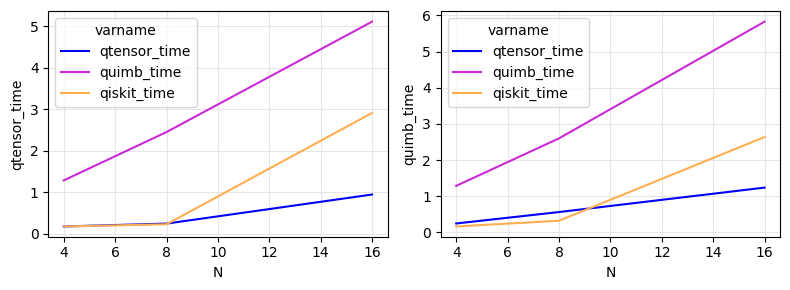

In [24]:
xar_tr = xar.transpose('p', 'varname', 'N')
#xar_tr = xar_tr.rename({'varname':'lib'})
fig = ex.plot_xarray(xar_tr)

In [25]:
#export
def plot_xar_data(xar_orig):
    xar = xar_orig.transpose('p', 'varname', 'N')
    def custom_plot(x, y, **kwargs):
        plt.plot(x, y, '*-', **kwargs)
        plt.yscale('log')
        plt.xscale('log', base=2)
    fig = ex.plot_xarray(xar, plot_func=custom_plot)

    axes = fig.axes
    axes[0].get_shared_y_axes().join(*axes)
    axes[0].get_shared_x_axes().join(*axes)
    ps = [x.data for x in xar.coords['p']]

    [ax.autoscale() for ax in axes]
    [ax.set_title(x) for ax, x in zip(axes, [f"p = {p}" for p in ps])]


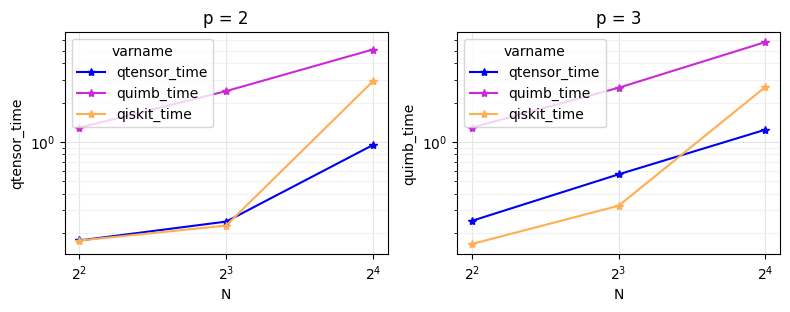

In [26]:
plot_xar_data(xar)

## CLI

In [ ]:
#export
from qtensor_specs import cli, click

In [ ]:
#export
@cli.command()
@click.option('-O', '--qtn_ordering_algo', default='greedy')
@click.argument(filename)
def time_comparison_xarray(filename, **kwargs):
    Ns = 2*(.5*np.pi**(np.arange(0, 11)/2)).astype(np.int) + 10
    ps = [2, 3, 4]
    xar = gen_time_data(Ns, ps, **kwargs)
    xar.to_netcdf(filename)
    

In [30]:
#hide
#default_exp speed_comparison

from nbdev.export  import *
notebook2script()

Converted QAOA_bench.ipynb.
Converted Speed_comparison.ipynb.
Converted Time_vs_FLOP.ipynb.
Converted index.ipynb.
